# User Data Analysis

In [1]:
#packages
import pandas as pd
import numpy as np
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Rigid body position heatmap

In [2]:
#FUNCTION DEFINITIONS

from mpl_toolkits.axes_grid1 import make_axes_locatable

def filterData(user_data, tag, startTime):
    data = user_data.loc[user_data['start'].str.contains(tag)]
    data = data.start.str.split(pat=' ',expand=True)
    data = data[data[0].astype(float) > startTime]
    return data
    
def generateHeatmapData(data, idx_x, idx_y, idx_z, limit, step):    
    heatsize = int(limit * 2 / step)
    heatmap_x_y = np.zeros( (heatsize, heatsize) , dtype=np.int64)#2.5 meters, 2500 mm x 2500 mm
    heatmap_x_z = np.zeros( (heatsize, heatsize) , dtype=np.int64)
    for index, row in data.iterrows():
        x = float(row[idx_x])
        y = float(row[idx_y])
        z = float(row[idx_z])
        if (x > -limit) and (x < limit) and (y > -limit) and (y < limit) and (z > -limit) and (z < limit):
            i = int((x + limit) / step)
            j = int((y + limit) / step)
            k = int((z + limit) / step)
            heatmap_x_y[j][i] += 1
            heatmap_x_z[k][i] += 1
    return heatmap_x_y, heatmap_x_z

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def createIndividualHeatmap(data, limitNumber, fig, ax, hAxisName, vAxisname, hColor, vColor, cmap, fontsize):
    plot = ax.imshow(NormalizeData(data), extent=[-limitNumber, limitNumber, limitNumber,- limitNumber], cmap=cmap)
    ax.invert_yaxis()
    fig.set_facecolor('white')
    ax.grid(visible = True, axis = 'y', color = 'w')
    ax.grid(visible = True, axis = 'x', color = 'w')
    arrowSize = 0.2
    ax.arrow(0, 0, arrowSize, 0, width = 0.02, color = hColor)
    ax.arrow(0, 0, 0, arrowSize, width = 0.02, color = vColor)
    ax.set_xlabel('Meters ' + hAxisName, fontsize = fontsize)
    ax.set_ylabel('Meters '+ vAxisname, fontsize = fontsize)
    ax.tick_params(axis='x', labelsize= fontsize)
    ax.tick_params(axis='y', labelsize= fontsize)
    return plot

def createRoomHeatmap(heatmap_x_y, heatmap_x_z, cmap, limit):
    #print(heatmap_x_y.shape)
    plt.style.use('classic')
    #plt.rcParams.update(plt.rcParamsDefault)    
    boundary = limit / 1000 #hack -0.5

    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    plot0 = createIndividualHeatmap(heatmap_x_y, boundary, fig, axs[0], 'X', 'Y', 'red', 'lime', cmap, 'medium')
    plot1 = createIndividualHeatmap(heatmap_x_z, boundary, fig, axs[1], 'X', 'Z', 'red', 'blue', cmap, 'medium')
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad= 0.05)   
    plt.colorbar(plot1, cax=cax)
    plt.show()

    plt.rcParams.update(plt.rcParamsDefault)

In [93]:
# User data and start time
user_id = 2
user_data = pd.read_csv('./FinalDatasets/users/user-'+str(2)+'.txt')
start_data = user_data.loc[user_data['start'].str.contains('globalstart')]# if not it assumes it is all data BE CAREFUL HERE
startTime = 0
if start_data.shape[0] > 0:
    startTime = float(start_data.values[0][0].split()[0])
    print('Start Time: ' + str(startTime))
endTime = float(user_data.iloc[len(user_data) - 2]['start'].split()[0])
limit = 3000
step = 200
print(endTime)

Start Time: 4461335.61
6729297.681


<Figure size 640x480 with 0 Axes>

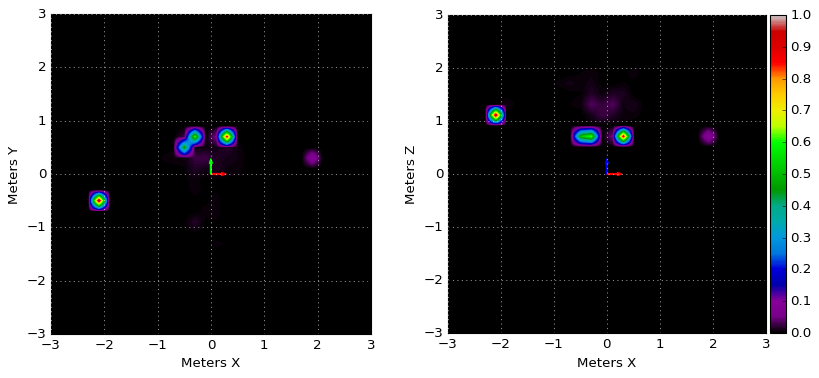

<Figure size 640x480 with 0 Axes>

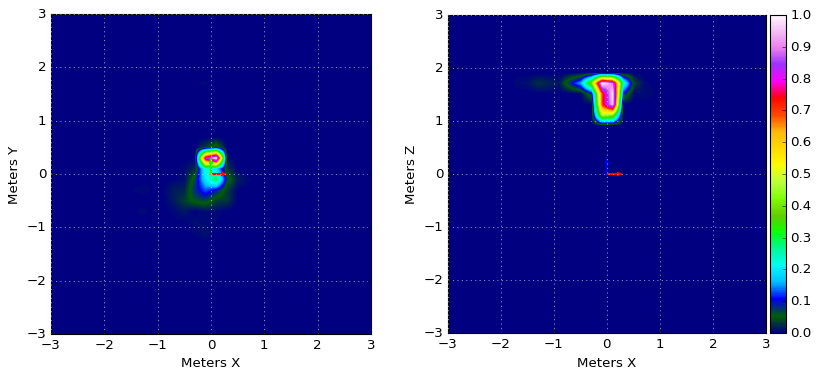

In [4]:
# MOCAP data

mocap_data = filterData(user_data, 'mocap', startTime)
heatmap_x_y, heatmap_x_z = generateHeatmapData(mocap_data, 2, 3, 4, limit, step)    
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'nipy_spectral', limit)

# HOLO data

holo_data = filterData(user_data, 'holo', startTime)
holo_posdir_data = holo_data.loc[holo_data[2].str.contains('/gazedir')]

#pos: 3, 4, 5 dir:6, 7, 8 
heatmap_x_y, heatmap_x_z = generateHeatmapData(holo_posdir_data, 3, 4, 5, limit, step)    
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'gist_ncar', limit)


<Figure size 640x480 with 0 Axes>

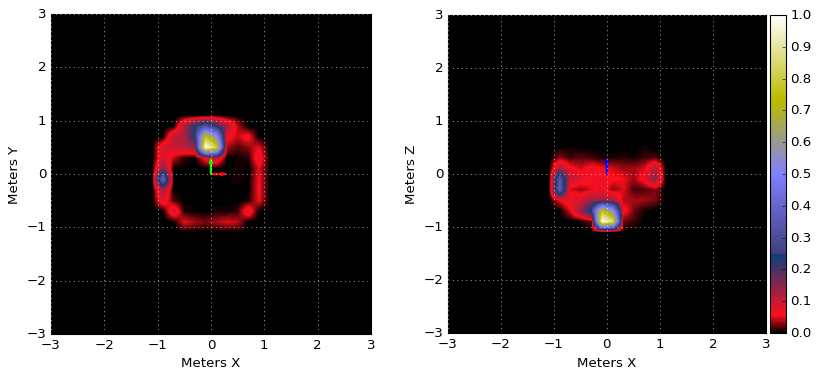

In [5]:
#pos: 3, 4, 5 dir:6, 7, 8 
heatmap_x_y, heatmap_x_z = generateHeatmapData(holo_posdir_data, 6, 7, 8, limit, step)    
createRoomHeatmap(heatmap_x_y, heatmap_x_z, 'gist_stern', limit)

In [6]:
agents_data = filterData(user_data, 'agents', startTime)
agents_data = agents_data[agents_data[1].str.contains('agents')]# discard holo

In [7]:
def convertSaveInt(n):
    try:
        return int(n)
    except:
        return 0
    
def setAgentInfo(dic, id, time, state, x, y, z):
    if id not in dic:
        dic[id] = []
    info = {}    
    info['time'] = time
    info['state'] = state
    info['x'] = x
    info['y'] = y
    info['z'] = z
    dic[id].append(info)

agents_info = {}
init_index_row = 2
for index, row in agents_data.iterrows():
    agent_info_id = convertSaveInt(row[0 + init_index_row])
    agent_info_time = float(row[0])
    agent_info_state = convertSaveInt(row[1 + init_index_row])
    agent_info_x = convertSaveInt(row[2 + init_index_row])
    agent_info_y = convertSaveInt(row[3 + init_index_row])
    agent_info_z = convertSaveInt(row[4 + init_index_row])
    agents_size = convertSaveInt(row[5 + init_index_row])
    setAgentInfo(agents_info, agent_info_id, agent_info_time, agent_info_state, agent_info_x, agent_info_y, agent_info_z)
    for i in range(0, agents_size):
        agent_info_id = convertSaveInt(row[i * 4 + 6 + init_index_row])
        agent_info_time = float(row[0])
        agent_info_state = 2;#released state
        agent_info_x = convertSaveInt(row[i * 4 + 7 + init_index_row])
        agent_info_y = convertSaveInt(row[i * 4 + 8 + init_index_row])
        agent_info_z = convertSaveInt(row[i * 4 + 9 + init_index_row])
        setAgentInfo(agents_info, agent_info_id, agent_info_time, agent_info_state, agent_info_x, agent_info_y, agent_info_z)   

In [8]:
#Heatmaps per each agent
agents_size = 8
heatmap_agents_x_y = [] 
heatmap_agents_x_z = []
for i in range (0, agents_size):
    agent_df = pd.DataFrame(agents_info[i])
    agent_df = agent_df[agent_df['state'] == 2] #while it is released
    heatmap_x_y, heatmap_x_z = generateHeatmapData(agent_df, 2, 3, 4, limit, step)
    heatmap_agents_x_y.append(heatmap_x_y)
    heatmap_agents_x_z.append(heatmap_x_z)

<Figure size 640x480 with 0 Axes>

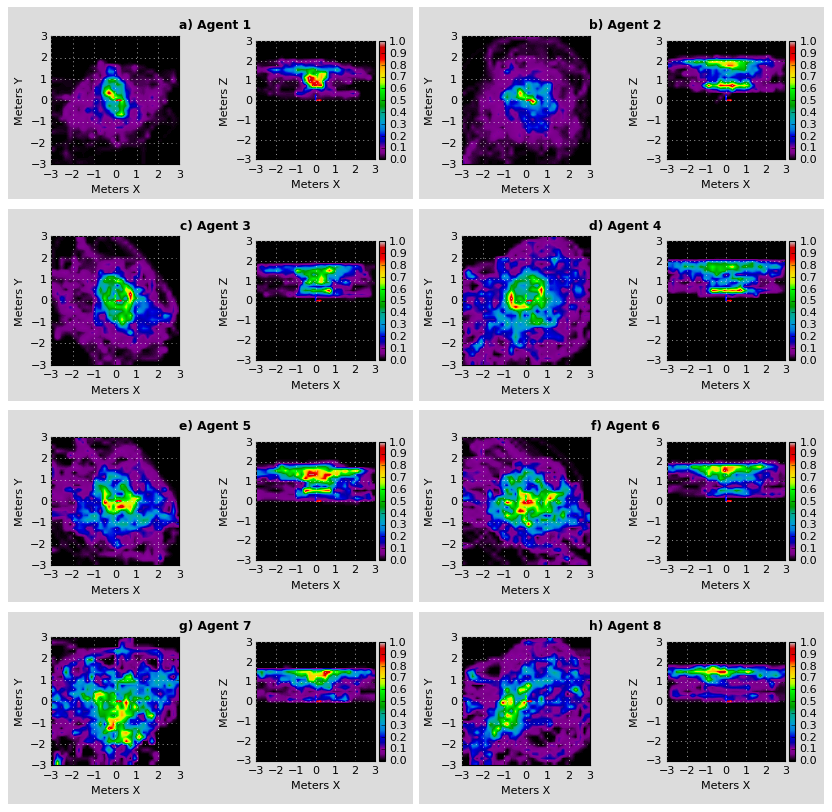

In [9]:
def createRoomMultiHeatmap(user_id, heatmap_x_y, heatmap_x_z, cmap, limit):
    #print(heatmap_x_y.shape)
    plt.style.use('classic')
    #plt.rcParams.update(plt.rcParamsDefault)    
    boundary = limit / 1000 #hack -0.5
    size = len(heatmap_x_y) # or the other heatmap sould be the same

    plt.figure()
    fig, axs = plt.subplots(int(size / 2), 2 * 2, figsize=(12,5 * size * 0.3))
    fontsize = 'small'
    for i in range(0, size):
        plot0 = createIndividualHeatmap(heatmap_x_y[i], boundary, fig, axs[int(i / 2)][(i * 2) % 4], 'X', 'Y', 'red', 'lime', cmap, fontsize)
        plot1 = createIndividualHeatmap(heatmap_x_z[i], boundary, fig, axs[int(i / 2)][(i * 2) % 4 + 1], 'X', 'Z', 'red', 'blue', cmap, fontsize)
        axs[int(i / 2)][(i * 2) % 4 + 1].set_title(str(chr(96 + i + 1)) + ') Agent ' + str(i + 1), x=-0.35, y=1.06, fontsize = 11, fontweight='heavy')
        divider = make_axes_locatable(axs[int(i / 2)][(i * 2) % 4 + 1])
        cax = divider.append_axes("right", size="5%", pad= 0.05)   
        cax.tick_params(labelsize= fontsize) 
        plt.colorbar(plot1, cax=cax)
    for i in range(0, 8):
        h = 0 if i < 4 else 1;
        rect = Rectangle((0.08 + 0.428 * h, 0.71 - 0.21 * (i % 4)), 0.422, 0.20, facecolor='gainsboro', edgecolor='none',
                     transform=fig.transFigure, zorder=-1)
        fig.patches.append(rect)
    #fig.tight_layout()   
    plt.subplots_adjust(wspace=0.6)
    plt.savefig('figures/all_agents_heatmaps_user_'+str(user_id)+'.pdf', bbox_inches='tight')
    plt.show()   

    plt.rcParams.update(plt.rcParamsDefault)

createRoomMultiHeatmap(user_id, heatmap_agents_x_y, heatmap_agents_x_z, 'nipy_spectral', limit)

In [41]:
holo_fov_data = holo_data.loc[holo_data[2].str.contains('/fovagents')]
holo_fov_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
6215,4516880.077,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
6234,4517112.138,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
6253,4517434.956,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
6270,4517643.011,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
6289,4517962.794,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190418,6712539.920,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
190441,6712813.215,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
190461,6713015.006,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,
190484,6713293.905,holo,/fovagents,0,0,1,0,2,0,3,0,4,0,5,0,6,0,7,0,


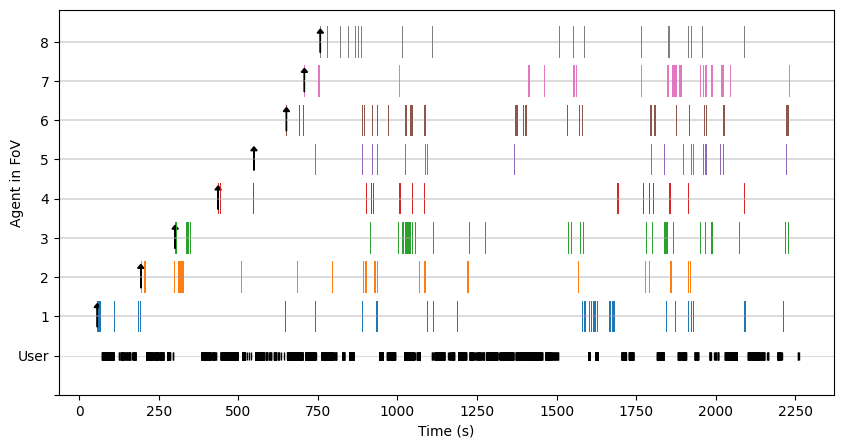

In [208]:
# Field of view time chart

colors = plt.rcParams["axes.prop_cycle"]()
plt.figure(figsize=(10, 5))
agent_count = 0
for agent_index in range (4, 19, 2):
    #print(agent_index)
    agent_count += 1
    i = 0
    start_times = []
    end_times = []
    startTaken = False
    while i < (len(holo_fov_data) - 1):
        irow = holo_fov_data.iloc[i]
        if irow[agent_index] == '1':
            if not startTaken:
                start_times.append(float(irow[0]))
                startTaken = True
            for j in range(i + 1, len(holo_fov_data) - 1):
                iNextRow = holo_fov_data.iloc[j]
                if iNextRow[agent_index] == '1':
                    i = j - 1
                    break
            diff = float(iNextRow[0]) - float(irow[0])
            if(diff > 1000):#Consider that more than 1 sec is out of view
                end_times.append(float(irow[0]))
                start_times.append(float(iNextRow[0]))
                #print(diff)
        i += 1

    #holo_fov_data          
    if(len(start_times) > len(end_times)):
        start_times.pop(-1)
    #print(len(start_times))
    #print(len (end_times))
    start_times = (np.array(start_times) - startTime) * 0.001
    end_times = (np.array(end_times) - startTime) * 0.001

    current_color = next(colors)["color"]    
    for i in range(0, len(start_times)):
        plt.axhline(agent_count, linewidth=0.01, color='gainsboro')
        plt.barh(agent_count,  end_times[i]-start_times[i], left=start_times[i], color = current_color) 
        if i == 0:
            arrowSize = 0.5
            plt.gca().arrow(start_times[i], agent_count - arrowSize * 0.55, 0, arrowSize,head_width = 20 , head_length = 0.1, width = 0.5, color = 'black')

ticks = np.arange(0, (endTime - startTime) * 0.001, 250)
plt.xticks(ticks)

midi_data = filterData(user_data, 'midicontroller', startTime)
plt.axhline(0, linewidth=0.8, color='gainsboro', zorder = -1)
plt.plot((midi_data[0].astype(float) - startTime) * 0.001,[0] * len(midi_data), '|', color='black')
yticks = np.arange(-1, agents_size + 1, step=1)
plt.yticks(yticks)
labelsY = yticks.astype(np.str)#[item.get_text() for item in ax.get_yticklabels()]
labelsY[0] = ''
labelsY[1] = 'User'
plt.gca().set_yticklabels(labelsY)
plt.gca().yaxis.set_label_coords(-0.045,0.55)

plt.ylabel('Agent in FoV')
plt.xlabel('Time (s)')
plt.show()


In [138]:
# Time in which agents are "LOCKED" 

agent_count = 0
agents_start_times = []
agents_end_times = []
for agent_index in range (0, agents_size):
    #print(agent_index)
    agent_count += 1
    i = 0
    start_times = []
    end_times = []
    startTaken = False
    agent_df = pd.DataFrame(agents_info[agent_index])
    while i < (len(agent_df) - 1):
        irow = agent_df.iloc[i]
        if irow['state'] == 1:
            if not startTaken:
                start_times.append(float(irow[0]))
                startTaken = True
            for j in range(i + 1, len(agent_df) - 1):
                iNextRow = agent_df.iloc[j]
                if iNextRow['state'] == 1:
                    i = j - 1
                    break
            diff = float(iNextRow[0]) - float(irow[0])
            if(diff > 1000):#Consider that more than 1 sec is out of view
                end_times.append(float(irow[0]))
                start_times.append(float(iNextRow[0]))
                #print(diff)
        i += 1
         
    if(len(start_times) > len(end_times)):
        start_times.pop(-1)

    start_times = (np.array(start_times) - startTime) * 0.001
    end_times = (np.array(end_times) - startTime) * 0.001
    agents_start_times.append(start_times)
    agents_end_times.append(end_times)

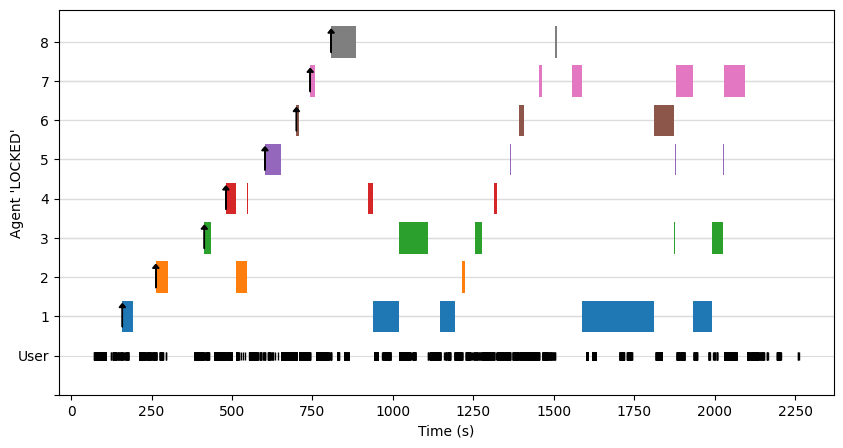

In [207]:
colors = plt.rcParams["axes.prop_cycle"]()
plt.figure(figsize=(10, 5))
for agent_index in range (0, agents_size):    
    current_color = next(colors)["color"]    
    for i in range(0, len(agents_start_times[agent_index])):        
        plt.axhline(agent_index + 1, linewidth=0.8, color='gainsboro', zorder = -1)
        plt.barh(agent_index + 1,  agents_end_times[agent_index][i]-agents_start_times[agent_index][i], left=agents_start_times[agent_index][i], color = current_color)        
        if i == 0:
            arrowSize = 0.5
            plt.gca().arrow(agents_start_times[agent_index][i], agent_index + 1 - arrowSize * 0.55, 0, arrowSize,head_width = 20 , head_length = 0.1, width = 0.5, color = 'black')

ticks = np.arange(0, (endTime - startTime) * 0.001, 250)
plt.xticks(ticks)

midi_data = filterData(user_data, 'midicontroller', startTime)
plt.axhline(0, linewidth=0.8, color='gainsboro', zorder = -1)
plt.plot((midi_data[0].astype(float) - startTime) * 0.001,[0] * len(midi_data), '|', color='black')
yticks = np.arange(-1, agents_size + 1, step=1)
plt.yticks(yticks)
labelsY = yticks.astype(np.str)#[item.get_text() for item in ax.get_yticklabels()]
labelsY[0] = ''
labelsY[1] = 'User'
plt.gca().set_yticklabels(labelsY)
plt.gca().yaxis.set_label_coords(-0.045,0.55)


plt.ylabel('Agent \'LOCKED\'')
plt.xlabel('Time (s)')
plt.show()

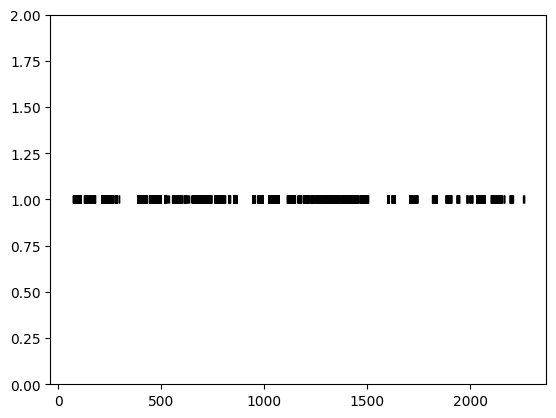

In [144]:
# Midi controller data

# MOCAP data



plt.figure()
plt.plot((midi_data[0].astype(float) - startTime) * 0.001,[1] * len(midi_data), '|', color='black')
plt.ylim([0, 2])
plt.show()
